# Read the preprocessed Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
df=pd.read_csv("../../Data/ml-latest-small/PreprocessedData_ml_latest_year_small.csv",index_col=0)
df.head()

,userId,movieId,rating,title,genres,year
0,1,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,5,1,4.0,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
2,7,1,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
3,15,1,2.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
4,17,1,4.5,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995


# Further Processing the Data (optional)

## Genre management

In [2]:
#genres = df_prelim.genres.str.get_dummies(sep = "|")

#df = pd.concat([df_prelim, genres], axis=1)
#df = df.drop(['genres'], axis = 1)
#df.head()

In [3]:
#making all titles lower case
df["title"] = df["title"].str.lower()

# Collaborative Filtering (CF)

The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context.

## 0. User Input

In [4]:
def AskForUserInput_0():
    fav_movie=input("Enter your Favorite Movie: ").lower()
    n=0
    movies=df["title"].unique()
    while fav_movie not in movies and n<5:
        print("The Movie ", fav_movie," does not exist in our database.")
        fav_movie = input("Please enter another favourite Movie: ").lower()
        n+=1
    return fav_movie

## 1.  Model 1: Memory Based Approach, Item-Item Collaborative Filtering, N Neighbours

**This is NOT a Machine Learning Model**

> Memory Based Collaborative Filtering:
>
> Take a matrix of preferences for items by users using this matrix 
> to predict missing preferences and recommend items
> There are two types of memory based models:
>> 1) Item-Item Collaborative Filtering: “Users who liked this item also liked …”
>>
>> (i.e. starting from a given movie (or set of movies) we find similar movies based on other users’ preferences.)
>>
>> 2) User-Item Collaborative Filtering: “Users who are similar to you also liked …”
>>
>> (i.e. find users that have seen/rated similar content, and use their preferences to recommend new items)
>
> Memory Based Filtering Pros:
>> 1) Easy to implement
>>
>> 2) produce reasonable prediction quality
>
>Cons:
>> 1) It tends to recommend popular items.
>> 2) It suffers when new items that don’t have any ratings enter the system.

### 1. Create a Pivot Matrix 

We pivot the dataframe to have userId as rows and movieId as columns. 

In [5]:
df_movie_pivot = df.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)
df_movie_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.  Sparse matrix

A lot of values n the above matrix are zero, i.e. the data is extremely sparse.

> A sparse matrix is a matrix that is comprised of mostly zero values.

> Convert into an Array Matrix by using csr_matrix


In [6]:
from scipy.sparse import csr_matrix
feature_matrix=csr_matrix(df_movie_pivot.values)

### 3. Build the Model

In [7]:
from sklearn.neighbors import NearestNeighbors
#We only consider 10 nearest neighbours
n_neigh=10
model_knn_rating=NearestNeighbors(metric="cosine",n_neighbors=n_neigh)
model_knn_rating.fit(feature_matrix)

NearestNeighbors(metric='cosine', n_neighbors=10)

### 4. Create The Function to recommend movies

In [8]:
def recommend_movie_by_rating(query_title):
    
    #Find the movie ID w.r.t the the title
    query_index=df[df['title']==query_title]['movieId'].unique()[0]
    
    distances,indices=model_knn_rating.kneighbors(
        df_movie_pivot.iloc[query_index,:].values.reshape(1,-1)
    )
    
    MovieIds=[]
    CosDistance=[]
    ratedBy=[]
    
    for i in range(0,len(distances.flatten())):
        movieId=df_movie_pivot.index[indices.flatten()[i]]
        MovieIds.append(movieId)
    
        CosDistance.append(distances.flatten()[i])
        ratedBy.append(len(df[df['movieId']==movieId]['rating']))
        
    df_out=df[df.movieId.isin(MovieIds)].drop(["userId"],axis=1)
    
    df_out=df_out.groupby(['movieId','title',"year","genres"]).mean()
    df_out['average rating']=df_out['rating'].round(2)
    df_out=df_out.drop(['rating'],axis=1)
    df_out['number of ratings']=ratedBy
    df_out['Cosine Distance, ML Model']=CosDistance
    df_out['Cosine Distance, ML Model']=df_out['Cosine Distance, ML Model'].round(2)
    print("Because You like the movie",query_title,"we'd recommend you to watch:")
    display(df_out.head(10))

    #Results are automatically sorted as in the pivot table the indices are the movie ids

### 5. Test 

In [9]:
input_movie=AskForUserInput_0()
recommend_movie_by_rating(input_movie)

Enter your Favorite Movie: Toy Story
Because You like the movie toy story we'd recommend you to watch:


,,,,average rating,number of ratings,"Cosine Distance, ML Model"
movieId,title,year,genres,,,
2,jumanji,1995,Adventure|Children|Fantasy,3.43,110,0.00
19,ace ventura: when nature calls,1995,Comedy,2.73,172,0.41
364,"lion king, the",1994,Adventure|Animation|Children|Drama|Musical|IMAX,3.94,144,0.45
367,"mask, the",1994,Action|Comedy|Crime|Fantasy,3.18,157,0.46
480,jurassic park,1993,Action|Adventure|Sci-Fi|Thriller,3.75,238,0.46
500,mrs. doubtfire,1993,Comedy|Drama,3.39,116,0.48
551,"nightmare before christmas, the",1993,Animation|Children|Fantasy|Musical,3.55,93,0.48
586,home alone,1990,Children|Comedy,3.00,183,0.48
588,aladdin,1992,Adventure|Animation|Children|Comedy|Musical,3.79,146,0.49


### 6. Save Your Model

In [10]:
import pickle
filename = 'Model_1_NearestNeighbours_ratingbased.sav'
pickle.dump(model_knn_rating, open(filename, 'wb'))

## 2. Model 2: Collaborative Filtering, item-item, K-means

In this approach, CF models are developed using **machine learning algorithms** to predict user’s rating of unrated items. 

> We will use **Surprise**
>> Surprise is a Python scikit for building and analyzing recommender systems that deal with explicit rating data.



### 1. Load Surprise Data from DataFrame, Train-Test Split

In [11]:
from surprise import accuracy
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise.model_selection import train_test_split,cross_validate,RandomizedSearchCV
from surprise import KNNWithMeans
from surprise import KNNBasic
reader = Reader()

#delete unnecessary columns away
df_imp=df.drop(['title','year','genres'],axis=1)

surprise_data = Dataset.load_from_df(df_imp, reader)
trainset, testset = train_test_split(surprise_data, test_size=.25,random_state=10)

In [12]:
def find_best_model(model, parameters,data):
    clf = RandomizedSearchCV(model, parameters, n_jobs=-1, measures=['rmse'])
    clf.fit(data)             
    print(clf.best_score)
    print(clf.best_params)
    print(clf.best_estimator)
    return clf

### 2. Find Optimal k using RandomizedSearchCV

In [13]:
sim_options = {
    "name": ["cosine", "pearson", "pearson_baseline"],"user_based": [False]
}
params = { 'k': range(2,25,1),'sim_options': sim_options}
clf = find_best_model(KNNWithMeans, params, surprise_data)

{'rmse': 0.8831359072457424}
{'rmse': {'k': 23, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}}
{'rmse': <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x7f8f4c97c4f0>}


### 3. Build Model using best parameters

In [14]:
knnwithmeans = clf.best_estimator['rmse']

### Load Recommender System Class and other important Functions

In [15]:
%run Functions.ipynb 

### Recommendation Functions, only for this notebook

> Users and items have a raw id and an inner id. Some methods will use/return a raw id (e.g. the predict() method), while some other will use/return an inner id.

> Raw ids are ids as defined in a rating file or in a pandas dataframe. They can be strings or numbers. Note though that if the ratings were read from a file which is the standard scenario, they are represented as strings. This is important to know if you’re using e.g. predict() or other methods that accept raw ids as parameters.

> On trainset creation, each raw id is mapped to a unique integer called inner id, which is a lot more suitable for Surprise to manipulate. Conversions between raw and inner ids can be done using the to_inner_uid(), to_inner_iid(), to_raw_uid(), and to_raw_iid() methods of the trainset.


In [16]:
def recommend_similar_items(movie_title, df, model, n=5):
        movieId=df[df['title']==movie_title]['movieId'].unique()[0]
        inner_movieId=model.trainset.to_inner_iid(movieId)
        
        movie_neighbours=model.get_neighbors(inner_movieId,n)
        
        df_out=df[df.movieId.isin([model.trainset.to_raw_iid(inner_id)
                       for inner_id in movie_neighbours])].drop(["userId"].drop_duplicates(),axis=1)
        
        df_out=df_out.groupby(['movieId','title',"year","genres"]).mean()
        df_out['average rating']=df_out['rating'].round(2)
        df_out=df_out.drop(['rating'],axis=1)
        df_out['number of ratings']=len(df[df.movieId.isin(movie_neighbours)]['rating'])
        
        return df_out 

In [17]:
CF_knnwithmeans = collab_filtering_Kmeans_Model(knnwithmeans,trainset,testset)

### 5. Fit, predict and cross-validate

In [18]:
knnwithmeans_rmse,knnwithmeans_recommenddf =CF_knnwithmeans.fit_and_predict(df)

**Fitting the train data...**
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
**Predicting the test data...**
RMSE: 0.8901
**RMSE for the predicted result is 0.89**


In [19]:
knnwithmeans_cv_rmse_cv = CF_knnwithmeans.cross_validate(surprise_data)
mean_cv_RMSE_result = round(knnwithmeans_cv_rmse_cv['test_rmse'].mean(),3)
print('**Mean CV RMSE is ' + str(mean_cv_RMSE_result)  + '**')

**Cross Validating the data...**
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8840  0.8918  0.8741  0.8841  0.8837  0.8835  0.0056  
MAE (testset)     0.6730  0.6780  0.6673  0.6713  0.6707  0.6721  0.0035  
Fit time          8.46    8.53    8.93    8.97    8.81    8.74    0.21    
Test time         9.14    9.15    9.60    9.36    9.50    9.35    0.19    
**Mean CV RMSE is 0.884**


### Model Errors Plot

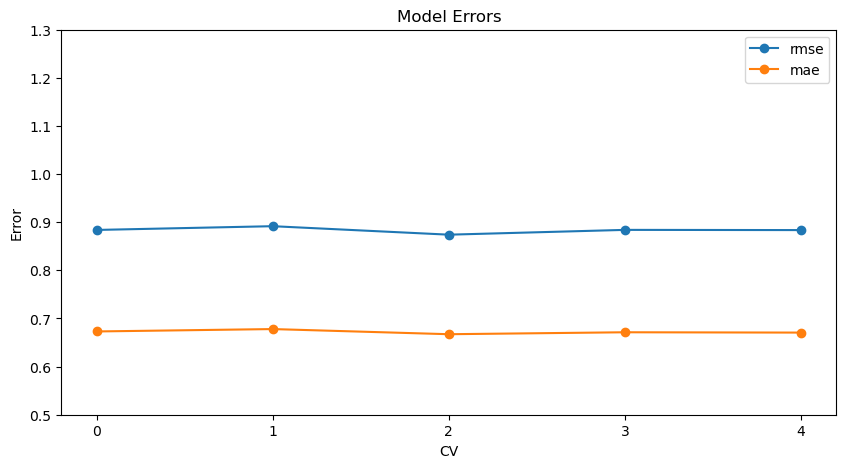

In [20]:
# Get data
rmse = knnwithmeans_cv_rmse_cv['test_rmse']
mae = knnwithmeans_cv_rmse_cv['test_mae']
x = np.arange(len(rmse))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize = (10, 5))
plt.xticks(np.arange(min(x), max(x) + 1, 1.0))
plt.ylim(0.5, 1.3)
ax.plot(x, rmse, marker='o', label="rmse")
ax.plot(x, mae, marker='o', label="mae")

# Chart setup
plt.title("Model Errors", fontsize = 12)
plt.xlabel("CV", fontsize = 10)
plt.ylabel("Error", fontsize = 10)
plt.legend()
plt.show()


### 7. Recommend (Item Based)

In [21]:
inp_movie=AskForUserInput(df)
df_out=recommend_similar_items(inp_movie,df,CF_knnwithmeans.model, n=10)
print("Because You like the movie",inp_movie,"we'd recommend you to watch:")
display(df_out.head(10))

Enter your Favorite Movie: Toy Story
Because You like the movie toy story we'd recommend you to watch:


,,,,average rating,number of ratings
movieId,title,year,genres,,
364,"lion king, the",1994,Adventure|Animation|Children|Drama|Musical|IMAX,3.94,480
588,aladdin,1992,Adventure|Animation|Children|Comedy|Musical,3.79,480
1073,willy wonka & the chocolate factory,1971,Children|Comedy|Fantasy|Musical,3.87,480
1097,e.t. the extra-terrestrial,1982,Children|Drama|Sci-Fi,3.77,480
1270,back to the future,1985,Adventure|Comedy|Sci-Fi,4.04,480
2716,ghostbusters,1984,Action|Comedy|Sci-Fi,3.78,480
2797,big,1988,Comedy|Drama|Fantasy|Romance,3.72,480
3114,toy story 2,1999,Adventure|Animation|Children|Comedy|Fantasy,3.86,480
8961,"incredibles, the",2004,Action|Adventure|Animation|Children|Comedy,3.84,480


### 7. Save Your Model

In [23]:
import pickle
filename = 'Model_2_KNN_Means_ratingbased.sav'
pickle.dump(CF_knnwithmeans, open(filename, 'wb'))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matr